In [1]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting files


In [3]:
def extract_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    return dataframes


extracted = extract_files("/content/drive/MyDrive/Topic_modelling")

In [4]:
alldata = pd.DataFrame()
for listitems in extracted:
    alldata = pd.concat([alldata, listitems])

## Feature extraction

In [5]:
alldata.head()

,headlines,description,content,url,category
0,CUET PG 2024: Register with NTA to enable admi...,CUET PG 2024: UGC said that the list of partic...,The Common University Entrance Test Postgradua...,https://indianexpress.com/article/education/cu...,education
1,Oxford ends ties with TCS iON over technical g...,"On April 10, 2023 TCS had announced that it ha...",Less than a year after the Oxford University s...,https://indianexpress.com/article/education/ox...,education
2,"Enrollments in Computer Engineering surge, mec...",AISHE Report 2021-22: The enrollment in STEM (...,Student enrollments in Computer Engineering ha...,https://indianexpress.com/article/education/en...,education
3,"NDMC plans to provide free JEE, NEET UG coachi...",The coaching partner will also provide up-to-d...,The New Delhi Municipal Council (NDMC) is invi...,https://indianexpress.com/article/education/nd...,education
4,"BA courses register highest enrollment, maximu...",AISHE Report 2021-22: For programmes including...,Bachelor of Arts (BA) courses had the highest ...,https://indianexpress.com/article/education/ba...,education


In [6]:
targets = alldata["category"]
feature = alldata["content"]

In [7]:
print(targets.unique())

['education' 'business' 'entertainment' 'sports' 'technology']


In [7]:
VALIDATION_SPLIT = 0.25
TRAIN_SPLIT = 0.8

nb_training_samples = int(TRAIN_SPLIT * feature.shape[0])
nb_validation_samples = int(VALIDATION_SPLIT * feature.shape[0])

#Train/Test sets
x_train, x_test = feature[:nb_training_samples], feature[nb_training_samples:]
y_train, y_test = targets[:nb_training_samples], targets[nb_training_samples:]

# validation sets
x_valid = x_train[-nb_validation_samples:]
y_valid = y_train[-nb_validation_samples:]

In [89]:
maxlen = 100
embedding_dim = 100
max_words = 10000

classnames = {
    0 : 'Business',
    1 : 'Education',
    2 : 'Entertainment',
    3 : 'Sports',
    4 : 'Technology'
}

### Prepare pretained word embeddings

In [94]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors.' % len(embeddings_index))

found 400000 word vectors.


In [95]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [96]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [97]:
my_callbacks = [
    lr_scheduler,
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=10, min_lr=0.0001),
    keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)
]

### Using pretrained word embeddings


In [98]:
# Tokenize feature

from tf_keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(feature)
sequences = tokenizer.texts_to_sequences(feature)

word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(targets)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (10000, 100)
Shape of label tensor: (10000,)


In [99]:
VALIDATION_SPLIT = 0.25
TRAIN_SPLIT = 0.7

nb_training_samples = int(TRAIN_SPLIT * data.shape[0])
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

#Train/Test sets
x_train, x_test = data[:nb_training_samples], data[nb_training_samples:]
y_train, y_test_real = labels[:nb_training_samples], labels[nb_training_samples:]

# validation sets
x_valid = x_train[-nb_validation_samples:]
y_valid = y_train[-nb_validation_samples:]

In [23]:
print(y_train[0:10])
#print(type(y_valid))

['technology' 'education' 'entertainment' 'sports' 'entertainment'
 'business' 'sports' 'education' 'education' 'sports']


In [100]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

In [101]:
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test_real)
y_test_coms = encoder.transform(y_test_real)

In [102]:
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

In [103]:
print(y_train)

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


### Model with Word embeddings


In [118]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    input_length = maxlen,
                    weights = [embedding_matrix],
                    trainable = False))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(LSTM(32, recurrent_dropout=0.25, unroll=True))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

model.summary()
model.save("model.keras")

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 conv1d_38 (Conv1D)          (None, 94, 32)            22432     
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_39 (Conv1D)          (None, 12, 32)            7200      
                                                                 
 max_pooling1d_39 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 lstm_18 (LSTM)              (None, 32)              

In [119]:
from gc import callbacks
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [120]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data = (x_valid, y_valid),
                    callbacks = my_callbacks)

Epoch 1/10
70/70 [==============================] - 4s 18ms/step - loss: 1.4727 - accuracy: 0.3339 - val_loss: 0.8256 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - 1s 15ms/step - loss: 0.6785 - accuracy: 0.7674 - val_loss: 0.2336 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - 1s 13ms/step - loss: 0.3712 - accuracy: 0.8906 - val_loss: 0.1961 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 4/10
70/70 [==============================] - 1s 15ms/step - loss: 0.3035 - accuracy: 0.9144 - val_loss: 0.1801 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 5/10
70/70 [==============================] - 1s 13ms/step - loss: 0.2534 - accuracy: 0.9301 - val_loss: 0.1371 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 6/10
70/70 [==============================] - 1s 16ms/step - loss: 0.2236 - accuracy: 0.9439 - val_loss: 0.1062 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 7/10
70/70 [==============================] - 1s 18ms/step - loss: 0.1

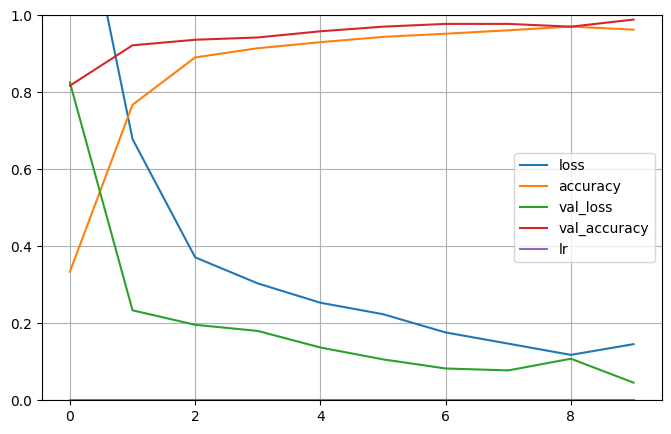

In [121]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [122]:
model.evaluate(x_test, y_test)

94/94 [==============================] - 1s 5ms/step - loss: 0.2549 - accuracy: 0.9377


[0.2548697590827942, 0.937666654586792]

In [123]:
class_names = targets.unique()
class_names

array(['education', 'business', 'entertainment', 'sports', 'technology'],
      dtype=object)

In [124]:
X_new = x_test[:10]
y_pred = np.argmax(model.predict(X_new), axis=1)
print(np.array(class_names)[y_pred])

y_preds = np.argmax(model.predict(x_test), axis=1)

1/1 [==============================] - 0s 363ms/step
['entertainment' 'technology' 'education' 'entertainment' 'entertainment'
 'sports' 'technology' 'education' 'entertainment' 'entertainment']
94/94 [==============================] - 0s 3ms/step


In [125]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
cm = classification_report(y_test_coms, y_preds)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       587
           1       0.97      0.94      0.95       587
           2       0.96      0.97      0.96       622
           3       0.96      0.96      0.96       601
           4       0.87      0.92      0.89       603

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Text(0.5, 1.0, 'Confusion Matrix Model with pretrained word embeddings')

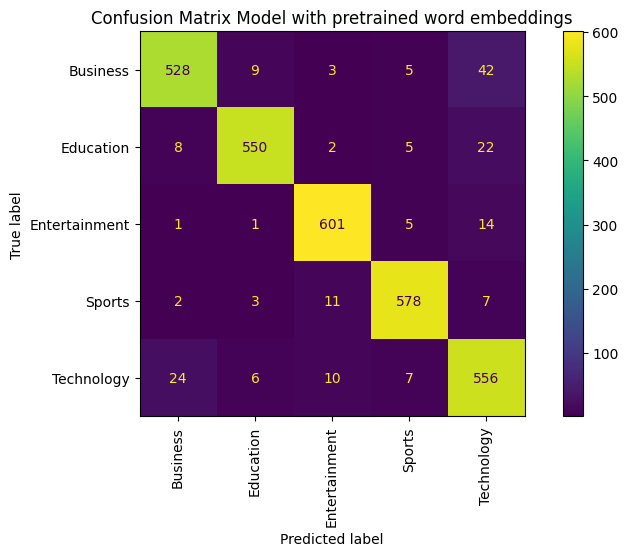

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test_coms, y_preds, ax=ax,
                                               xticks_rotation="vertical")
ax.xaxis.set_ticklabels(classnames.values())
ax.yaxis.set_ticklabels(classnames.values())
plt.title("Confusion Matrix Model with pretrained word embeddings")

In [127]:
import pickle

In [128]:
pickle.dump(model, open('modelreal.pkl', 'wb'))

In [129]:
pickled_model = pickle.load(open('modelreal.pkl', 'rb'))

In [131]:
ypred = np.argmax(pickled_model.predict(x_test), axis=1)

94/94 [==============================] - 0s 3ms/step


In [132]:
print(np.array(class_names)[y_pred])

['entertainment' 'technology' 'education' 'entertainment' 'entertainment'
 'sports' 'technology' 'education' 'entertainment' 'entertainment']
